In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed

In [2]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [81]:
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

In [3]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [4]:
GFM_SOLAR_METALLICITY = 0.0127

GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_HELIUM  =  (1.-GFM_SOLAR_ABUNDANCE_HYDROGEN -GFM_SOLAR_METALLICITY)
GFM_SOLAR_ABUNDANCE_CARBON  =  0.0024
GFM_SOLAR_ABUNDANCE_NITROGEN =  0.0007
GFM_SOLAR_ABUNDANCE_OXYGEN  =  0.0057
GFM_SOLAR_ABUNDANCE_NEON    =  0.0012
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_SILICON =  0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
GFM_SOLAR_ABUNDANCE_OTHER  =   0

HUBBLE = 3.2407789e-18
SEC_PER_MEGAYEAR = 3.15576e13

In [5]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [6]:
print(get_time(2, redshift=True))

3.287727935547831


In [7]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [92]:
def get_rot_pos_vel(snap, subhalo, ptype=4, rhalf_fac=2, phys=False):
    # get COM, COMV, and ang mom of stars
    COM = subhalo['SubhaloPos']
    pos = snap[4]['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    rhalf = subhalo['SubhaloHalfmassRadType'][4]
    print(rhalf)

    in_rhalf = r < 2 * rhalf
    is_star = snap[4]['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    vel_in_rhalf = snap[4]['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = snap[4]['Masses'][is_star_in_rhalf]
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    print(COMV)
    
    vel = snap[4]['Velocities'] - COMV
    
    ang = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    ang *= mass_in_rhalf.reshape(-1, 1)
    ang = np.sum(ang, axis=0)
    
    ang_mom = ang

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    print(angmom_dir)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    pos = snap[ptype]['Coordinates'] - COM
    vel = snap[ptype]['Velocities'] - COMV
    mass = snap[ptype]['Masses']
    
    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
    
    # if phys:
    #     pos_rot *= meta['header'][].Time/meta['header'][].HubbleParam
    #     vel_rot *= np.sqrt(meta['header'][].Time)
    
    return pos_rot, vel_rot, mass

In [101]:
subID = 523889

subhalo = il.groupcat.loadSingle(TNGbase, 99, subhaloID=subID)

In [102]:
snap = {}
snap[4] = il.snapshot.loadSubhalo(TNGbase, 99, subID, 4)
snap[3] = il.snapshot.loadSubhalo(TNGbase, 99, subID, 3)

In [103]:
pos, vel, mass = get_rot_pos_vel(snap, subhalo, rhalf_fac=1)

3.4344184
[-198.0273  -127.60852  -84.05695]
[ 0.36309068 -0.72906581  0.58019669]


In [104]:
np.sum(np.cross(pos, vel) * mass.reshape(-1, 1), axis=0)

array([  25.20768449,  -12.51515993, 2281.43151514])

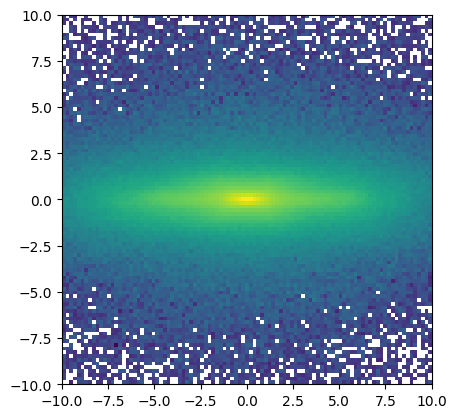

In [105]:
is_star = snap[4]['GFM_StellarFormationTime'] > 0

xbins = np.linspace(-10, 10, 100)
ybins = np.linspace(-10, 10, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(pos[is_star][:,0], pos[is_star][:,2], mass[is_star], 
                                                     statistic='sum', bins=[xbins, ybins])
    
fig, ax = plt.subplots(1, 1)
    
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           norm=mpl.colors.LogNorm())
ax.set_aspect('equal')

In [106]:
pos, vel, mass = get_rot_pos_vel(snap, subhalo, rhalf_fac=1)

pos *= meta['header'][99].Time/meta['header'][99].HubbleParam
vel *= np.sqrt(meta['header'][99].Time)

R = np.linalg.norm(pos[:,:2], axis=1)
sphi = pos[:,1]/R
cphi = pos[:,0]/R
vphi = -sphi*vel[:,0] + cphi*vel[:,1]

Lz = R * vphi
Lzsun = 8 * 220
in_SN = np.logical_and(np.abs(Lz/Lzsun-1) < 0.1, np.abs(pos[:,2] < 3))
# in_SN = np.logical_and(np.logical_and(R > 6, R < 10), np.abs(pos[:,2]) < 3)


is_star = snap[4]['GFM_StellarFormationTime'] > 0
is_star_in_SN = np.logical_and(is_star, in_SN)

Z = snap[4]['GFM_Metallicity'] / GFM_SOLAR_METALLICITY
logZ = np.log10(Z)

FeH = snap[4]['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
logFeH = np.log10(FeH)

MgH = snap[4]['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
MgFe = MgH/FeH
logMgFe = np.log10(MgFe)

3.4344184
[-198.0273  -127.60852  -84.05695]
[ 0.36309068 -0.72906581  0.58019669]


[Text(0.5, 0, '[Fe/H]'), Text(0, 0.5, '[alpha/Fe]')]

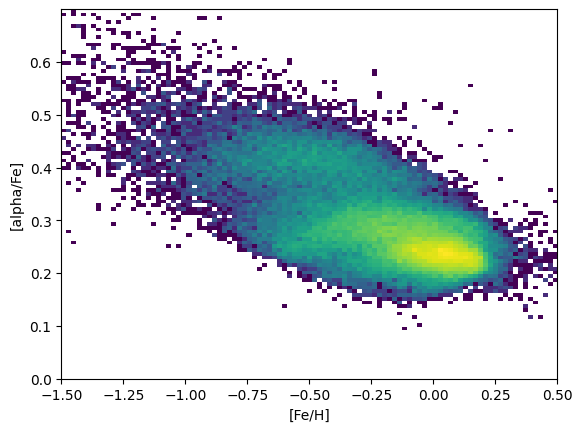

In [107]:
xbins = np.linspace(-1.5, 0.5, 100)
ybins = np.linspace(0, 0.7, 100)

x = logFeH[is_star_in_SN]
y = logMgFe[is_star_in_SN]

mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                     statistic='sum', bins=[xbins, ybins])
    
# mbin = mbin / np.sum(mbin, axis=1)
    
fig, ax = plt.subplots(1, 1)

im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
         norm=mpl.colors.LogNorm())

# fig.colorbar(im, ax=ax)

a_born = snap[4]['GFM_StellarFormationTime']
z_born = 1/a_born - 1

after_dip = np.logical_and(z_born[is_star_in_SN] > 0.8, z_born[is_star_in_SN] < 0.93)

ax.set_aspect('auto')
ax.set(xlabel='[Fe/H]', ylabel='[alpha/Fe]')

[Text(0.5, 0, '[Fe/H]'), Text(0, 0.5, '[alpha/Fe]')]

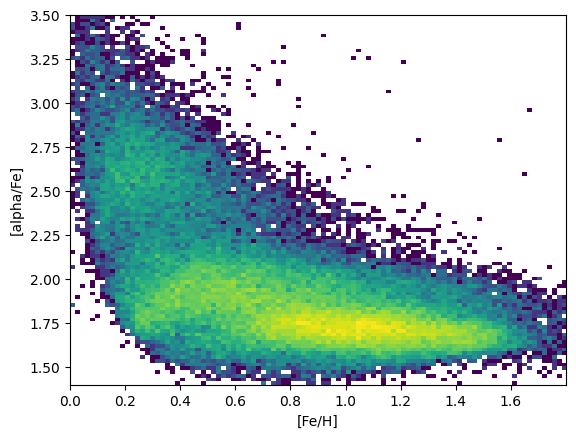

In [129]:
# xbins = np.linspace(-1.5, 0.5, 100)
# ybins = np.linspace(0, 0.7, 100)
xbins  = np.linspace(0.0, 1.8, 100)
ybins = np.linspace(1.4, 3.5, 100)

x = 10.**logFeH[is_star_in_SN]
y = 10.**logMgFe[is_star_in_SN]

mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                     statistic='sum', bins=[xbins, ybins])
    
# mbin = mbin / np.sum(mbin, axis=1)
    
fig, ax = plt.subplots(1, 1)

im = ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
               norm=mpl.colors.LogNorm())

# fig.colorbar(im, ax=ax)

a_born = snap[4]['GFM_StellarFormationTime']
z_born = 1/a_born - 1

after_dip = np.logical_and(z_born[is_star_in_SN] > 0.8, z_born[is_star_in_SN] < 0.93)

ax.set_aspect('auto')
ax.set(xlabel='[Fe/H]', ylabel='[alpha/Fe]')

In [109]:
a_born = snap[4]['GFM_StellarFormationTime']
t_born = get_time(a_born)
t0 = get_time(1)

Z = snap[4]['GFM_Metallicity'] / GFM_SOLAR_METALLICITY

FeH = snap[4]['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON

MgH = snap[4]['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
MgFe = MgH/FeH

avet = []
aveFe = []
aveMgFe = []
tmin = 0.0
dt = 0.01

while tmin < t0:
    key = np.logical_and(t_born > tmin, t_born < tmin + 0.2)
    avet.append(np.mean(t_born[key]))
    aveFe.append(np.mean(10.**FeH[key]))
    aveMgFe.append(np.mean(10.**MgFe[key]))
    
    
    tmin += dt

avet = np.array(avet)
aveFe = np.log10(np.array(aveFe))
aveMgFe = np.log10(np.array(aveMgFe))


/tmp/ipykernel_3438457/1229942710.py:22: RuntimeWarning: overflow encountered in power
  aveMgFe.append(np.mean(10.**MgFe[key]))


Text(0, 0.5, '[alpha/Fe]')

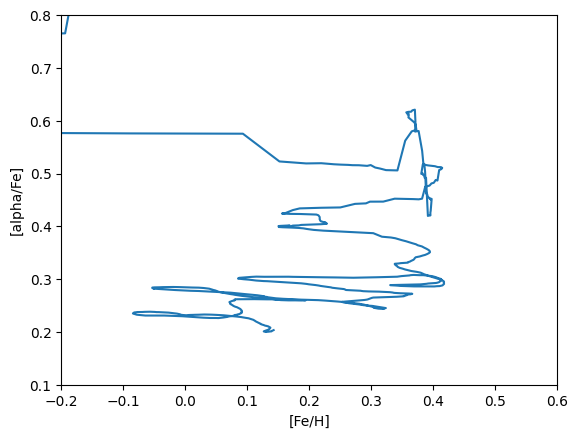

In [110]:
plt.plot(np.log10(aveFe), np.log10(aveMgFe))
plt.xlim(-0.2, 0.6)
plt.ylim(0.1, 0.8)
# plt.xlim(-1.5, 0.5)
# plt.ylim(0., 0.7)
plt.xlabel('[Fe/H]')
plt.ylabel('[alpha/Fe]')

Text(0, 0.5, '[Mg/Fe]')

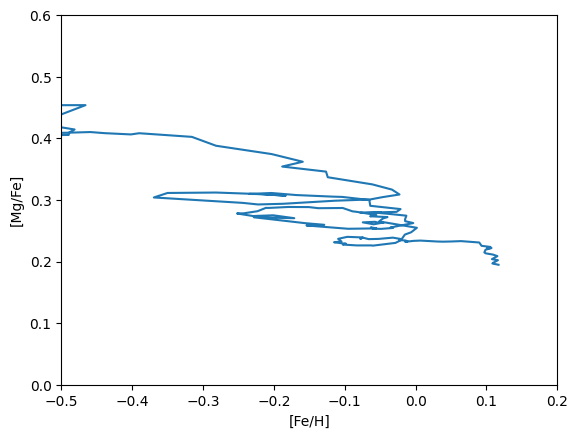

In [111]:
a_born = snap[4]['GFM_StellarFormationTime']
t_born = get_time(a_born)
t0 = get_time(1)

# t_born_meas = np.random.normal(t_born, 0.001 * t_born)
t_born_meas = t_born

# Z_bin, bin_edges, _ = binned_statistic(t_born_meas[is_star_in_SN], 10.**Z[is_star_in_SN], 
#                                         bins=np.linspace(0, t0, 200))

# FeH_bin, bin_edges, _ = binned_statistic(t_born_meas[is_star_in_SN], 10.**FeH[is_star_in_SN], 
#                                         bins=np.linspace(0, t0, 200))

# MgFe_bin, bin_edges, _ = binned_statistic(t_born_meas[is_star_in_SN], 10.**MgFe[is_star_in_SN], 
#                                         bins=np.linspace(0, t0, 200))

# Z_bin, FeH_bin, MgFe_bin = np.log10(Z_bin), np.log10(FeH_bin), np.log10(MgFe_bin)

Z_bin, bin_edges, _ = binned_statistic(t_born_meas[is_star_in_SN], Z[is_star_in_SN], 
                                        bins=np.linspace(0, t0, 200))

FeH_bin, bin_edges, _ = binned_statistic(t_born_meas[is_star_in_SN], FeH[is_star_in_SN], 
                                        bins=np.linspace(0, t0, 200))

MgFe_bin, bin_edges, _ = binned_statistic(t_born_meas[is_star_in_SN], MgFe[is_star_in_SN], 
                                        bins=np.linspace(0, t0, 200))

bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# plt.plot(bin_center, np.log10(Fe_bin))b
# plt.axvline(0.8)
# plt.axvline(0.93)

plt.plot(np.log10(FeH_bin), np.log10(MgFe_bin))
plt.xlim(-0.5, 0.2)
plt.ylim(0, 0.6)
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

(4.0, 8.0)

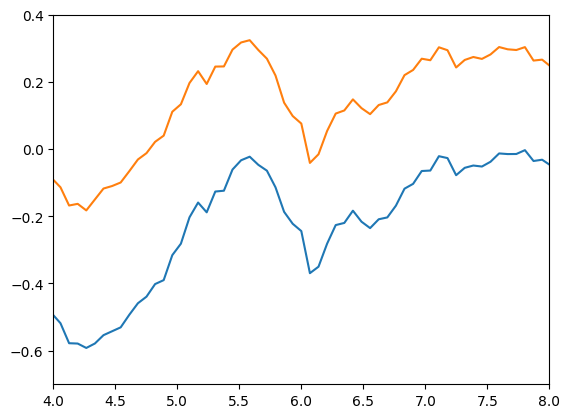

In [112]:
plt.plot(bin_center, np.log10(FeH_bin))
# plt.plot(bin_center, np.log10(MgFe_bin))
plt.plot(bin_center, np.log10(Z_bin))
# plt.axvline(0.8)
# plt.axvline(0.93)

plt.ylim(-0.7, 0.4)
plt.xlim(4, 8)

# plt.axvline(5.3)
# plt.axvline(5.5)

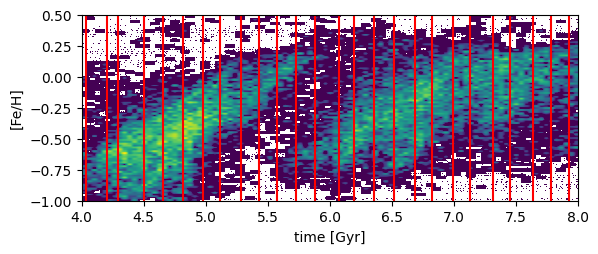

In [113]:

xbins = np.linspace(4, 8, 100)
ybins = np.linspace(-1, 0.5, 100)

x = t_born[is_star_in_SN]
y = logFeH[is_star_in_SN]

mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                     statistic='sum', bins=[xbins, ybins])
    
fig, ax = plt.subplots(1, 1)
    
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
         norm=mpl.colors.LogNorm())
ax.set_aspect('equal')

ax.set(xlabel='time [Gyr]', ylabel='[Fe/H]')

for i in meta['snap_list']:
    if meta['time'][i] > x_edge[0] and meta['time'][i] < x_edge[-1]:
        ax.axvline(meta['time'][i], c='r')

# ax.axvline(meta['time'][48], c='r')
# t0 = meta['time'][48]-0.1
# t1 = meta['time'][48]+0.1
# ax.axvline(t0, c='r', ls='dashed')
# ax.axvline(t1, c='r', ls='dashed')
# ax.axvline(meta['time'][48-2], c='r')

# t0 = meta['time'][50]-0.1
# t1 = meta['time'][50]+0.1
# ax.axvline(t0, c='g', ls='dashed')
# ax.axvline(t1, c='g', ls='dashed')
# ax.axvline(meta['time'][50-2], c='g')
# ax.axvline(0.8)
# ax.axvline(0.93)

# print(meta['time'][50] - meta['time'][50-2])
# print(meta['time'][48] - meta['time'][48-2])


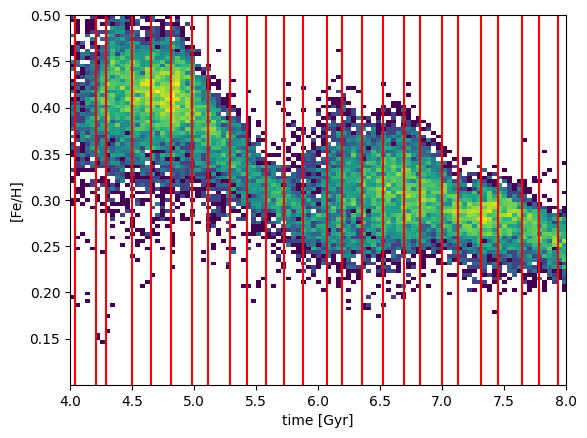

In [114]:

xbins = np.linspace(4, 8, 100)
ybins = np.linspace(0.1, 0.5, 100)

x = t_born[is_star_in_SN]
y = logMgFe[is_star_in_SN]

mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                     statistic='sum', bins=[xbins, ybins])
    
fig, ax = plt.subplots(1, 1)
    
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
         norm=mpl.colors.LogNorm())
ax.set_aspect('auto')

ax.set(xlabel='time [Gyr]', ylabel='[Fe/H]')

for i in meta['snap_list']:
    if meta['time'][i] > x_edge[0] and meta['time'][i] < x_edge[-1]:
        ax.axvline(meta['time'][i], c='r')

# ax.axvline(meta['time'][48], c='r')
# t0 = meta['time'][48]-0.1
# t1 = meta['time'][48]+0.1
# ax.axvline(t0, c='r', ls='dashed')
# ax.axvline(t1, c='r', ls='dashed')
# ax.axvline(meta['time'][48-2], c='r')

# t0 = meta['time'][50]-0.1
# t1 = meta['time'][50]+0.1
# ax.axvline(t0, c='g', ls='dashed')
# ax.axvline(t1, c='g', ls='dashed')
# ax.axvline(meta['time'][50-2], c='g')
# ax.axvline(0.8)
# ax.axvline(0.93)

# print(meta['time'][50] - meta['time'][50-2])
# print(meta['time'][48] - meta['time'][48-2])


In [ ]:

xbins = np.linspace(4, 8, 100)
ybins = np.linspace(-1, 0.5, 100)

x = t_born[is_star_in_SN]
y = logFeH[is_star_in_SN]

mbin, x_edge, y_edge, _ = binned_statistic_2d(x, y, np.ones(len(x)), 
                                                     statistic='sum', bins=[xbins, ybins])
    
fig, ax = plt.subplots(1, 1)
    
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
         norm=mpl.colors.LogNorm())
ax.set_aspect('equal')

ax.set(xlabel='time [Gyr]', ylabel='[Fe/H]')

In [118]:
FeH[is_star_in_SN]-aveFe_pred[is_star_in_SN]

array([0.67276904,        nan, 0.95331004, ..., 0.58019508, 0.77272953,
       0.74314716])

[None, Text(0, 0.5, 'residual [Mg/Fe]'), Text(0.5, 0, 'residual [Fe/H]')]

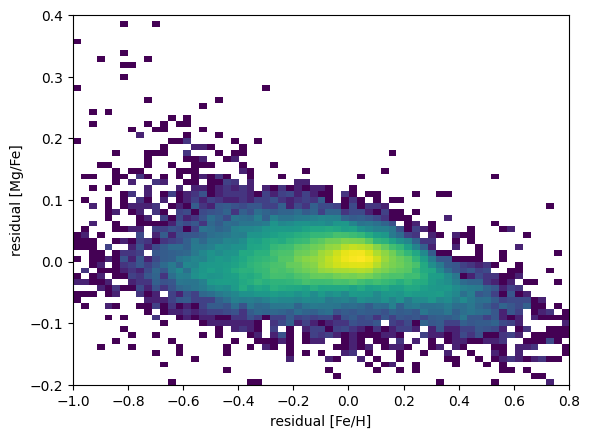

In [121]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(-1, 0.8, 64)
MgFe_bins = np.linspace(-0.2, 0.4, 64)

FeH = 10.**logFeH
MgFe = 10.**logMgFe

aveFe, _, _ = binned_statistic(t_born[is_star_in_SN], FeH[is_star_in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(t_born[is_star_in_SN], MgFe[is_star_in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(t_born[is_star_in_SN], t_born[is_star_in_SN], bins=age_bins)
aveFe = np.log10(aveFe)
aveMgFe = np.log10(aveMgFe)

aveFe_interp = interp1d(aveage, aveFe, bounds_error=False, fill_value='extrapolate')
aveMgFe_interp = interp1d(aveage, aveMgFe, bounds_error=False, fill_value='extrapolate')

aveFe_pred = aveFe_interp(t_born)
aveMgFe_pred = aveMgFe_interp(t_born)

fig, ax = plt.subplots(1, 1)

mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[is_star_in_SN]-aveFe_pred[is_star_in_SN], logMgFe[is_star_in_SN]-aveMgFe_pred[is_star_in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax.set(aspect='auto', ylabel='residual [Mg/Fe]', xlabel='residual [Fe/H]')

# mbin, x_edge, y_edge, _ = binned_statistic_2d(t_form[in_SN], MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
#                                                      statistic='sum', bins=[age_bins, MgFe_bins])
# ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
# ax[1].set(aspect='auto', xlabel='formation time [Gyr]', ylabel='[Mg/Fe]')
# ax[1].plot(aveage, aveMgFe)

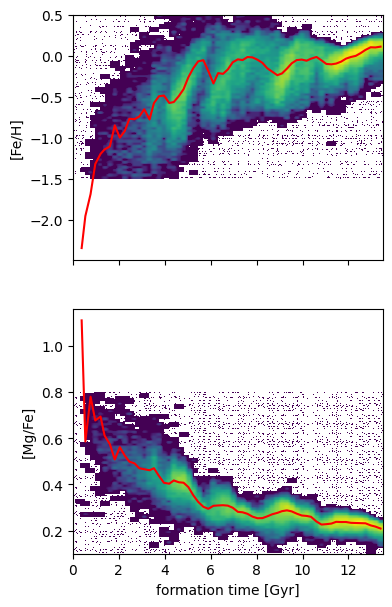

In [128]:
age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(-1.5, 0.5, 64)
MgFe_bins = np.linspace(0.1, 0.8, 64)

FeH = 10.**logFeH
MgFe = 10.**logMgFe

aveFe, _, _ = binned_statistic(t_born[is_star_in_SN], FeH[is_star_in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(t_born[is_star_in_SN], MgFe[is_star_in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(t_born[is_star_in_SN], t_born[is_star_in_SN], bins=age_bins)
logaveFe = np.log10(aveFe)
logaveMgFe = np.log10(aveMgFe)

fig, ax = plt.subplots(2, 1, figsize=(4, 7), sharex=True)

mbin, x_edge, y_edge, _ = binned_statistic_2d(t_born[is_star_in_SN], logFeH[is_star_in_SN], np.full(len(np.where(is_star_in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, FeH_bins])
ax[0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0].plot(aveage, logaveFe, c='r')
ax[0].set(aspect='auto', ylabel='[Fe/H]')

mbin, x_edge, y_edge, _ = binned_statistic_2d(t_born[is_star_in_SN], logMgFe[is_star_in_SN], np.full(len(np.where(is_star_in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, MgFe_bins])
ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1].set(aspect='auto', xlabel='formation time [Gyr]', ylabel='[Mg/Fe]')
ax[1].plot(aveage, logaveMgFe, c='r')

In [127]:
for i in np.arange(20, 35):
    print(i, meta['time'][i])

20 1.466035018475291
21 1.5403905827194986
22 1.6884973741252571
23 1.8119021110155575
24 1.9441696567054463
25 2.1453830103130693
26 2.237727043488033
27 2.383552028068521
28 2.5385996291098327
29 2.6845874642216585
30 2.838660539295044
31 2.9804158136757444
32 3.1289319094911066
33 3.2844834161372742
34 3.447349023325743


In [30]:
t0 = meta['time'][48]-0.1
t1 = meta['time'][48]+0.1
high_time = np.logical_and(t_born > t0, t_born < t1)
high_Fe = np.logical_and(logFeH > -0.25, logFeH < 0.0)
key_high = np.logical_and(np.logical_and(is_star_in_SN, high_time), high_Fe)

t0 = meta['time'][50]-0.1
t1 = meta['time'][50]+0.1
low_time = np.logical_and(t_born > t0, t_born < t1)
low_Fe = np.logical_and(logFeH > -1, logFeH < -0.5)
key_low = np.logical_and(np.logical_and(is_star_in_SN, low_time), low_Fe)

print(len(np.where(key_high)[0]))
print(len(np.where(key_low)[0]))

532
576


In [31]:
tree = il.sublink.loadTree(TNGbase, 99, subID, fields=['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassType', 'SnapNum', 'SubfindID'])

In [32]:
def maxPastMass(tree, index, ptNum=4):
    """ Get maximum past mass (of the given partType) along the main branch of a subhalo
        specified by index within this tree. """
    # ptNum = partTypeNum(partType)

    branchSize = tree['MainLeafProgenitorID'][index] - tree['SubhaloID'][index] + 1
    masses = tree['SubhaloMassType'][index: index + branchSize, ptNum]
    return np.max(masses)

In [33]:
index=0

numMergers = 0
massPartType = 1

minMassRatio = 0.1
invMassRatio = 1.0 / minMassRatio

rootID = tree['SubhaloID'][index]
print(rootID)
print(tree['SubfindID'][index])
fpID   = tree['FirstProgenitorID'][index]

while fpID != -1:
    fpIndex = index + (fpID - rootID)
    fpMass  = maxPastMass(tree, fpIndex, massPartType)
    
    npID = tree['NextProgenitorID'][fpIndex]
    
    while npID != -1:
        npIndex = index + (npID - rootID)
        npMass  = maxPastMass(tree, npIndex, massPartType)

        # count if both masses are non-zero, and ratio exceeds threshold
        if fpMass > 0.0 and npMass > 0.0:
            ratio = npMass / fpMass

            # print(ratio)
            
            if ratio >= minMassRatio and ratio <= invMassRatio:
                snapnum_fp = tree['SnapNum'][fpIndex]
                snapnum_np = tree['SnapNum'][npIndex]
                this_header = arepo.Snapshot(TNGbase, snapnum_fp, onlyHeader=True)
                z = 1./this_header.Time - 1
                print(snapnum_fp, snapnum_np, round(z, 3), round(1/ratio, 3), 
                      tree['SubfindID'][fpIndex], tree['SubfindID'][npIndex])
                numMergers += 1

        npID = tree['NextProgenitorID'][npIndex]
    
    fpID = tree['FirstProgenitorID'][fpIndex]

20000002400000000
523889
33 32 2.002 1.245 216570 209943
6 6 9.002 4.148 21946 21948
4 4 9.997 9.877 15357 15366
3 3 10.976 6.1 22485 22487


In [34]:
subhalo_fp = il.groupcat.loadSingle(TNGbase, 33, subhaloID=216570)
subhalo_np = il.groupcat.loadSingle(TNGbase, 32, subhaloID=209943)

rdiff = subhalo_fp['SubhaloPos'] - subhalo_np['SubhaloPos']
rdiff = np.linalg.norm(rdiff)
print(rdiff)

164.00394


In [56]:
def get_progenitor_snap(snapnum, subID):
    treeMPB = il.sublink.loadTree(TNGbase, 99, subID, onlyMPB=True)
    key = int(np.where(treeMPB['SnapNum'] == snapnum)[0])
    subID_snap = treeMPB['SubfindID'][key]

    subhalo_snap = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID_snap)

    sn = {}
    sn[4] = il.snapshot.loadSubhalo(TNGbase, snapnum, subID_snap, 4)
    sn[0] = il.snapshot.loadSubhalo(TNGbase, snapnum, subID_snap, 0)

    pos, vel, mass = get_rot_pos_vel(sn, subhalo_snap, ptype=0, rhalf_fac=2, phys=False)
    pos *= meta['scale_factor'][snapnum] / meta['header'][snapnum].HubbleParam
    vel *= np.sqrt(meta['scale_factor'][snapnum])
    
    sn[0]['RotatedCoordinates'] = pos
    sn[0]['RotatedVelocities'] = vel
    
    return sn

In [60]:
sn = {}
snapnum_list = [48, 50, 52, 54]
for snapnum in snapnum_list:
    sn[snapnum] = get_progenitor_snap(snapnum, subID)

4.101634
[-185.11284 -137.26549 -103.32135]
[ 0.5302321  -0.6671774   0.52319056]
3.7882652
[-178.54951 -112.89491  -70.42707]
[ 0.56082527 -0.62957022  0.5376954 ]
3.7788553
[-176.77869  -95.99769  -55.61257]
[ 0.5728834  -0.6336328   0.51991737]
3.7488627
[-190.06493 -112.06353  -72.67166]
[ 0.4666144  -0.7213425   0.51179683]


/tmp/ipykernel_3438457/2052726487.py:21: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(bin_center, nsf/ntot)


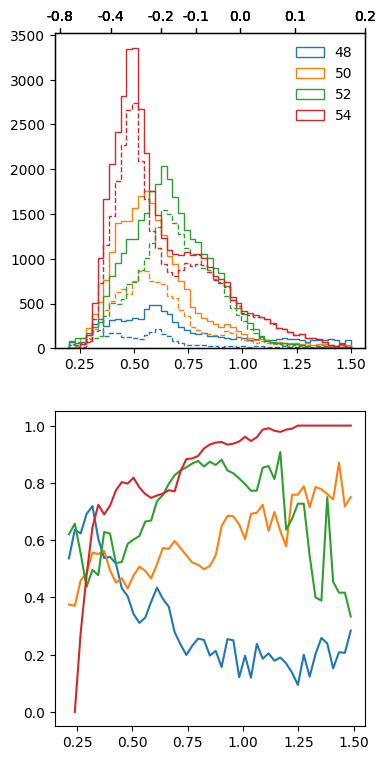

In [91]:
fig, ax = plt.subplots(2, 1, figsize=(4, 9))

for i,snapnum in enumerate(snapnum_list):
    pos = sn[snapnum][0]['RotatedCoordinates']
    vel = sn[snapnum][0]['RotatedVelocities']
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    in_SN = np.logical_and(R > 6, R < 10)
    in_SN = np.logical_and(in_SN, np.abs(z) < 3)
    in_SN_sf = np.logical_and(in_SN, sn[snapnum][0]['StarFormationRate'] > 0)

    ntot, bins, _ = ax[0].hist(sn[snapnum][0]['GFM_Metallicity'][in_SN]/GFM_SOLAR_METALLICITY, 
             bins=np.linspace(0.2, 1.5, 50), histtype='step', label=str(snapnum), color=new_colors[i]);
    bin_center = 0.5*(bins[:-1] + bins[1:])
    
    
    nsf, _, _ = ax[0].hist(sn[snapnum][0]['GFM_Metallicity'][in_SN_sf]/GFM_SOLAR_METALLICITY, 
             bins=np.linspace(0.2, 1.5, 50), histtype='step', ls='dashed', color=new_colors[i]);
    
    ax[1].plot(bin_center, nsf/ntot)
    
    ax[0].legend(frameon=False)
    
    ax2 = ax[0].twiny()
    label_metal = np.array([-0.8, -0.4, -0.2, -0.1, 0.0, 0.1, 0.2])
    ax2.set_xlim(ax[0].get_xlim())
    ax2.set_xticks(10.**label_metal)
    ax2.set_xticklabels(label_metal)
    
    # ax2 = plt.gca().twiny()
    # ax2.set_yscale("log")

In [78]:
dir(l[2][0])
l[2][0].get_facecolor()

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0)

## extract tracers

In [35]:
# snap_str = str(30).zfill(3)
# fbase = TNGbase + '/snapdir_'+ snap_str + '/snap_' + snap_str + '.'
# chunk = 36
# fields = ['Coordinates', 'GFM_Metals']
# TargetIDs = ParentID_33

# out = _load_single_tracer_prop(chunk, fbase, fields, TargetIDs)
# # for chunk in tqdm(range(192)):
#     # out = _load_single_tracer_prop(chunk, fbase, fields, TargetIDs)

In [36]:
# def get_tracer_ids(snapnum, subID, nproc=16):
if True:
    snapnum = 99
    nproc = 16
    subID = 523889
    
    header = arepo.Snapshot(TNGbase, snapnum, onlyHeader=True)
    subhalo = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    
    snap = {}
    snap[4] = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4)

    pos, vel, mass = get_rot_pos_vel(snap, subhalo, rhalf_fac=2)
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    
    a_born = snap[4]['GFM_StellarFormationTime']
    t_born = get_time(a_born)
    
    in_SN = np.logical_and(np.logical_and(R > 6, R < 10), np.abs(z) < 3)
    is_star = snap[4]['GFM_StellarFormationTime'] > 0
    is_star_in_SN = np.logical_and(is_star, in_SN)

    FeH = snap[4]['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)
    
    t0 = meta['time'][48]-0.1
    t1 = meta['time'][48]+0.1
    high_time = np.logical_and(t_born > t0, t_born < t1)
    high_Fe = np.logical_and(logFeH > -0.25, logFeH < 0.0)
    key_high = np.logical_and(np.logical_and(is_star_in_SN, high_time), high_Fe)

    t0 = meta['time'][50]-0.1
    t1 = meta['time'][50]+0.1
    low_time = np.logical_and(t_born > t0, t_born < t1)
    low_Fe = np.logical_and(logFeH > -1, logFeH < -0.5)
    key_low = np.logical_and(np.logical_and(is_star_in_SN, low_time), low_Fe)
    
    TargetIDs_high = snap[4]['ParticleIDs'][key_high]
    TargetIDs_low = snap[4]['ParticleIDs'][key_low]

3.4344184
[-198.0273  -127.60852  -84.05695]
[ 0.36309068 -0.72906581  0.58019669]


In [37]:
def _load_single_tracer_file(chunk, fbase, field, TargetIDs, match_parent=True):
    fname = fbase + str(chunk) + '.hdf5'
    
    with h5.File(fname, mode='r') as f:
        if 'PartType3' in f.keys():
            ParentID = f['PartType3/ParentID'][:]
            TracerID = f['PartType3/TracerID'][:]
            
            if match_parent:
                key = np.isin(ParentID, TargetIDs)
            else:
                key = np.isin(TracerID, TargetIDs)
            
            # key = np.isin(ParentID, TargetIDs)
            
            out = (TracerID[key], ParentID[key])
            
        else:
            out = (np.empty(0), np.empty(0))
    
    return out

def load_tracers(TNGbase, snapnum, field, TargetIDs, nproc=64, match_parent=True):
    snap_str = str(snapnum).zfill(3)
    fbase = TNGbase + '/snapdir_'+ snap_str + '/snap_' + snap_str + '.'
    
    fname0 = fbase + str(0) + '.hdf5'
    with h5.File(fname0, mode='r') as f0:
        NumFiles = f0['Header'].attrs['NumFilesPerSnapshot']
    
    out = Parallel(n_jobs=nproc) (delayed(_load_single_tracer_file)(i, fbase, field, TargetIDs, match_parent=match_parent) 
                                  for i in tqdm(range(NumFiles), position=0, leave=True))
    
    TracerID = np.concatenate([out[i][0] for i in range(len(out))])
    ParentID = np.concatenate([out[i][1] for i in range(len(out))])
    
    sort = np.argsort(TracerID)
    TracerID = TracerID[sort]
    ParentID = ParentID[sort]
    
    return TracerID, ParentID

In [71]:
from numba import njit
import numpy as np
@njit
def _MC_inner_loop(ParentIDs, ParticleIDs):
    key = np.full(ParentIDs.shape, -1)
    
    ilist = np.arange(len(ParentIDs))
    jlist = np.arange(len(ParticleIDs))
    
    ilist = ilist[np.argsort(ParentIDs)]
    jlist = jlist[np.argsort(ParticleIDs)]
    
    i_ = j_ = 0
    
    while i_ < len(ilist) and j_ < len(jlist):
        if ParentIDs[ilist[i_]] == ParticleIDs[jlist[j_]]:
            key[ilist[i_]] = jlist[j_]
            i_ += 1
        elif ParentIDs[ilist[i_]] > ParticleIDs[jlist[j_]]:
            j_ += 1
        else:
            i_ += 1
    
    return key

In [39]:
ParentIDs = np.array([1, 3, 3, 5, 12, 7])
ParticleIDs = np.array([0, 7, 1, 2, 3, 4, 6, 8, 9])

key = _MC_inner_loop(ParentIDs, ParticleIDs)
print(key)
# print(ParentIDs[key > -1])
# print(ParticleIDs[key[key > -1]])


[ 2  4  4 -1 -1  1]


In [76]:
def _load_single_tracer_prop(chunk, fbase, fields, ParentIDs, TracerIDs):
    fname = fbase + str(chunk) + '.hdf5'
    
    fld_shape = {}
    fld_shape['Coordinates'] = 3
    fld_shape['Velocities'] = 3
    fld_shape['BirthPos'] = 3
    fld_shape['BirthVel'] = 3
    fld_shape['MagneticField'] = 3
    fld_shape['GFM_Metals'] = 10
    
    out = {}
    for fld in fields:
        if fld_shape.get(fld, 1) > 1:
            out[fld] = [np.array([]).reshape(0, fld_shape.get(fld, 1))]
        else:
            out[fld] = [np.array([])]
    
    # out['PartType'] = [np.array([]).reshape(0, 1)]
    # out['ParticleIDs'] = [np.array([]).reshape(0, 1)]
    out['PartType'] = [np.array([], dtype=np.uint8)]
    out['ParticleIDs'] = [np.array([], dtype=np.uint64)]
    out['TracerID'] = [np.array([], dtype=np.uint64)]
    
    with h5.File(fname, mode='r') as f:
        for pt in [0, 4, 5]:
            pt_str = 'PartType' + str(pt)
            
            if pt_str in f.keys():
                PtypeIDs = f[pt_str + '/ParticleIDs'][:]
                
                key0 = np.isin(PtypeIDs, ParentIDs)
                key = _MC_inner_loop(ParentIDs, PtypeIDs)
                N = len(np.where(key > -1)[0])
                N0 = len(np.where(key0)[0])
                if N0 > 0:
                    print(chunk, pt_str, N, N0)
                
                if N == 0:
                    continue
                    
                out['PartType'].append(np.full(N, pt, dtype=np.uint8))
                out['ParticleIDs'].append(PtypeIDs[key[key > -1]]) # same as ParentIDs[key > -1]
                out['TracerID'].append(TracerIDs[key > -1])
                
                for fld in fields:
                    if fld in f[pt_str].keys():
                        out[fld].append( f[pt_str + '/' + fld][:][key[key > -1]] )
                    else:
                        shape = (N, fld_shape.get(fld, 1))
                        out[fld].append( np.full(shape, np.nan) )
    
    for key in out.keys():
        out[key] = np.concatenate(out[key])
    
    return out

def load_tracer_prop(TNGbase, snapnum, fields, ParentIDs, TracerIDs, nproc=64, match_parent=True):
    snap_str = str(snapnum).zfill(3)
    fbase = TNGbase + '/snapdir_'+ snap_str + '/snap_' + snap_str + '.'
    
    fname0 = fbase + str(0) + '.hdf5'
    with h5.File(fname0, mode='r') as f0:
        NumFiles = f0['Header'].attrs['NumFilesPerSnapshot']
    
    out = Parallel(n_jobs=nproc, backend='multiprocessing') (delayed(_load_single_tracer_prop)(i, fbase, fields, ParentIDs, TracerIDs) 
                                  for i in tqdm(range(NumFiles), position=0, leave=True))
    props = {}
    for key in out[0].keys():
        props[key] = np.concatenate([out[i][key] for i in range(len(out))])
        
    keysort = np.argsort(props['TracerID'])
    for key in props.keys():
        props[key] = props[key][keysort]
    
    return props

In [41]:
TracerID_high, ParentID_high = load_tracers(TNGbase, 99, 'ParentID', TargetIDs_high)
# TracerID_low, ParentID_low = load_tracers(TNGbase, 99, 'ParentID', TargetIDs_low)

100%|██████████| 680/680 [00:52<00:00, 12.99it/s]


In [42]:
# np.transpose([TracerID_high, ParentID_high])[:,0]
print(TracerID_high.shape)

(277,)


In [43]:
snap_high = 46
snap_low = 48
# header = arepo.Snapshot(TNGbase, snap, onlyHeader=True)
# print('z=', round(header.Redshift, 3))
# print('T_lb=', round(get_time(header.Time), 3))

In [44]:
TracerID_snap_h, ParentID_snap_h = load_tracers(TNGbase, snap_high, 'ParentID', TracerID_high, match_parent=False)
# TracerID_snap_l, ParentID_snap_l = load_tracers(TNGbase, snap_low, 'ParentID', TracerID_low, match_parent=False)

100%|██████████| 680/680 [00:56<00:00, 11.94it/s]


In [45]:
print(TracerID_snap_h.shape)
print(ParentID_snap_h.shape)
print(np.unique(ParentID_snap_h).shape)

(277,)
(277,)
(276,)


In [62]:
snap_str = str(snap_high).zfill(3)
fbase = TNGbase + '/snapdir_'+ snap_str + '/snap_' + snap_str + '.'
# for i in range(200):
    # print(i)
if True:
    i = 59
    _load_single_tracer_prop(i, fbase, ['Coordinates', 'Masses'], ParentID_snap_h, TracerID_snap_h)

59 PartType0 0 269


In [72]:
chunk = 59
fname = fbase + str(chunk) + '.hdf5'
with h5.File(fname, mode='r') as f:
    pt_str = 'PartType0'
    Ptype_ids = f[pt_str + '/ParticleIDs'][:]
    key0 = np.isin(Ptype_ids, ParentID_snap_h)

key = _MC_inner_loop(ParentID_snap_h, Ptype_ids)
    
# print(Ptype_ids)
# print(len(Ptype_ids))
# print(np.where(key)[0])

In [73]:
key

array([10715098, 10688782, 10704403, 10700505, 10691755, 10702163,
       11494109, 10704700, 10686607, 10714662, 10713696, 10715183,
       10704661, 10737538, 10719374, 10718124, 10657363, 10699838,
       10756671, 10701283, 10681007, 10696998, 10713788, 10864884,
       10709878, 10714359,       -1, 10724082, 10710055, 10668547,
       10666924, 10703594, 10674968, 10693952, 10701458, 10687817,
       10657622, 11112254, 10822408, 10661020, 10674434, 10700823,
       10696695, 10667887, 10713215, 10717659, 10671603, 10673421,
       10727336, 10684161, 10710611, 10694048, 10672309, 10694864,
       10667686, 10696367, 10764026, 10709562, 10659644, 10688528,
       10711967, 10674475, 10710358, 10677081,       -1, 10682756,
       10708549, 10713881, 10713152, 10694297, 10714248, 10782274,
       10718143, 10691639, 10681186, 10702194, 10711457, 10673150,
       10671835, 10709573, 10677642, 10700772, 10700292, 10809008,
       10851100, 10693843, 10694262, 10723927, 10792680, 10656

In [77]:
props_high = load_tracer_prop(TNGbase, snap_high, ['Coordinates', 'Masses'], ParentID_snap_h, TracerID_snap_h)
# props_low = load_tracer_prop(TNGbase, snap_low, ['Coordinates', 'Masses'], ParentID_snap_l)

  0%|          | 1/680 [00:00<05:25,  2.09it/s]

59 PartType0 270 269


 85%|████████▍ | 576/680 [00:44<00:06, 15.52it/s]

525 PartType4 7 7


100%|██████████| 680/680 [00:48<00:00, 14.11it/s]


In [81]:
props_high['PartType']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [71]:
fields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
          'FirstProgenitorID', 'SubhaloMassType', 'SnapNum', 'SubfindID']
tree = il.sublink.loadTree(TNGbase, 99, subID, fields=fields, onlyMPB=True)

In [72]:
k_snap_h = np.where(tree['SnapNum'] == snap_high)[0]
k_snap_l = np.where(tree['SnapNum'] == snap_low)[0]

prog_subID_h = tree['SubfindID'][k_snap_h]
prog_subID_l = tree['SubfindID'][k_snap_l]

prog_subhalo_h = il.groupcat.loadSingle(TNGbase, snap_high, subhaloID=prog_subID_h)
prog_subhalo_l = il.groupcat.loadSingle(TNGbase, snap_low, subhaloID=prog_subID_l)
    
COM_h = prog_subhalo_h['SubhaloPos']
COM_l = prog_subhalo_l['SubhaloPos']

# prog_fof = il.groupcat.loadSingle(TNGbase, snap, haloID=prog_subhalo['SubhaloGrNr'])

In [73]:
# sat_tree = il.sublink.loadTree(TNGbase, 32, 209943, fields=['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
#                  'FirstProgenitorID', 'SubhaloMassType', 'SnapNum', 'SubfindID'], onlyMPB=True)
# if snap <= 32:
#     ksat_snap = np.where(sat_tree['SnapNum'] == snap)[0]
#     prog_sat_subID = sat_tree['SubfindID'][ksat_snap]
#     prog_sat_subhalo = il.groupcat.loadSingle(TNGbase, snap, subhaloID=prog_sat_subID)

#     COM_sat = prog_sat_subhalo['SubhaloPos']    

In [74]:
pos_high = props_high['Coordinates'] - COM_h
r_high = np.linalg.norm(pos_high, axis=1)

pos_low = props_low['Coordinates'] - COM_l
r_low = np.linalg.norm(pos_low, axis=1)

(0.0, 100.0)

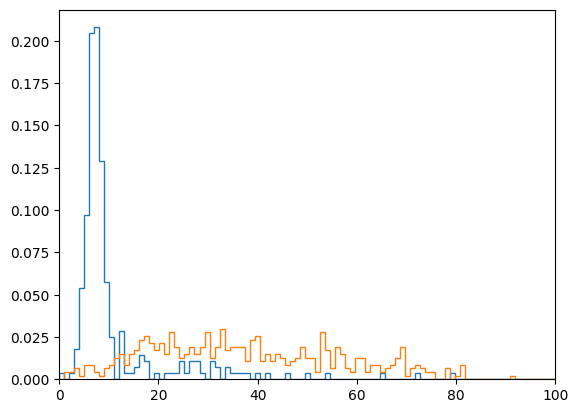

In [75]:
plt.hist(r_high, bins=np.linspace(0, 100, 100), histtype='step', density=True);
plt.hist(r_low, bins=np.linspace(0, 100, 100), histtype='step', density=True);
plt.xlim(0, 100)

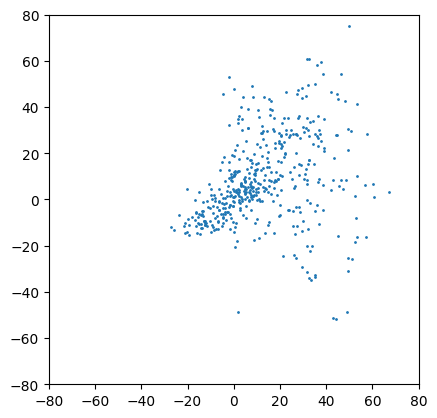

In [83]:
plt.scatter(pos_low[:,0], pos_low[:,1], s=1)
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.gca().set_aspect('equal')

In [122]:
def get_r_Menc(snap, haloID):
    # haloID_l = prog_subhalo_l['SubhaloGrNr']
    snap_halo = {}
    snap_halo[0] = il.snapshot.loadHalo(TNGbase, snap, haloID, 0, fields=['Coordinates', 'Masses'])
    snap_halo[1] = il.snapshot.loadHalo(TNGbase, snap, haloID, 1, fields=['Coordinates'])
    snap_halo[4] = il.snapshot.loadHalo(TNGbase, snap, haloID, 4, fields=['Coordinates', 'Masses'])
    snap_halo[5] = il.snapshot.loadHalo(TNGbase, snap, haloID, 5, fields=['Coordinates', 'Masses'])

    halo = il.groupcat.loadSingle(TNGbase, snap, haloID=haloID)
    COM = halo['GroupPos']

    G = 43018.7

    r0 = np.linalg.norm(snap_halo[0]['Coordinates'] - COM, axis=1)
    r1 = np.linalg.norm(snap_halo[1] - COM, axis=1)
    r4 = np.linalg.norm(snap_halo[4]['Coordinates'] - COM, axis=1)
    r5 = np.linalg.norm(snap_halo[5]['Coordinates'] - COM, axis=1)

    rlist = np.linspace(1, 100, 100)
    Menc_list = []
    for r in rlist:
        key0 = np.logical_and(r0 < r, r0 > r-1)
        key1 = np.logical_and(r1 < r, r1 > r-1)
        key4 = np.logical_and(r4 < r, r4 > r-1)
        key5 = np.logical_and(r5 < r, r5 > r-1)
    
        Menc = 0.0
        Menc += np.sum(snap_halo[0]['Masses'][key0])
        # Menc += meta['header'][snap_low].MassTable[1] * len(np.where(key1)[0])
        # Menc += np.sum(snap_halo[4]['Masses'][key4])
        # Menc += np.sum(snap_halo[5]['Masses'][key5])
    
        Menc_list.append(Menc)

    Menc_list = np.array(Menc_list)
    vcsq = G * Menc_list / rlist
    vc = np.sqrt(vcsq)

    vc_phys = vc * np.sqrt(meta['header'][snap_low].Time)
    rlist_phys = rlist * meta['header'][snap_low].Time

    tff = np.sqrt(2) * rlist_phys / vc_phys
    
    return rlist, Menc_list


In [125]:
rlist_l, Menc_l = get_r_Menc(snap_low, prog_subhalo_l['SubhaloGrNr'])
rlist_h, Menc_h = get_r_Menc(snap_high, prog_subhalo_h['SubhaloGrNr'])

(0.0, 0.08937602331861853)

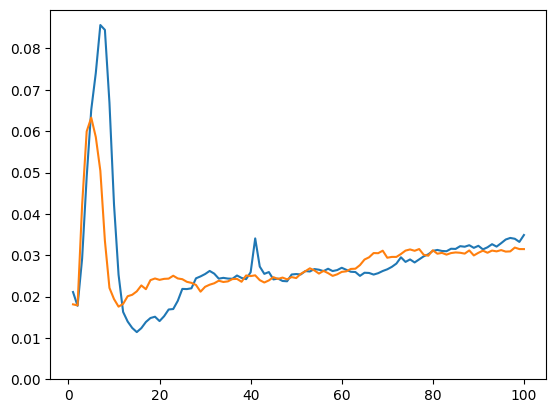

In [126]:
plt.plot(rlist_h, Menc_h)
plt.plot(rlist_l, Menc_l)
plt.ylim(0, None)

In [128]:
il.snapshot.loadHalo(TNGbase, snap_low, prog_subhalo_l['SubhaloGrNr'], 0, fields=None)

{'count': 787553,
 'Coordinates': array([[33662.434  ,   472.06918,  8763.97   ],
        [33662.434  ,   472.06805,  8763.97   ],
        [33662.54   ,   471.98596,  8764.032  ],
        ...,
        [33662.562  ,   472.55313,  8763.832  ],
        [33662.535  ,   472.38406,  8764.035  ],
        [33662.527  ,   472.33224,  8764.034  ]], dtype=float32),
 'Density': array([0.0202986 , 0.01929777, 0.01584811, ..., 0.00076018, 0.00280913,
        0.00110529], dtype=float32),
 'ElectronAbundance': array([1.1557605, 1.1555539, 1.1544209, ..., 1.1988059, 1.1986009,
        1.1991583], dtype=float32),
 'GFM_Metallicity': array([0.07319145, 0.07331081, 0.07354816, ..., 0.06966578, 0.07005077,
        0.07136214], dtype=float32),
 'InternalEnergy': array([  2882.31 ,   2834.504,   2651.449, ..., 201842.8  , 284725.44 ,
        475843.03 ], dtype=float32),
 'InternalEnergyOld': array([  2882.31 ,   2834.504,   2651.449, ..., 201842.8  , 284725.44 ,
        475843.03 ], dtype=float32),
 'Masses'

In [32]:
treeMPB = il.sublink.loadTree(TNGbase, 99, subID, onlyMPB=True)

treeMPB['Time'] = np.array([get_time(meta['header'][snap].Time) for snap in treeMPB['SnapNum']])

(0.0, 13.80271998548524)

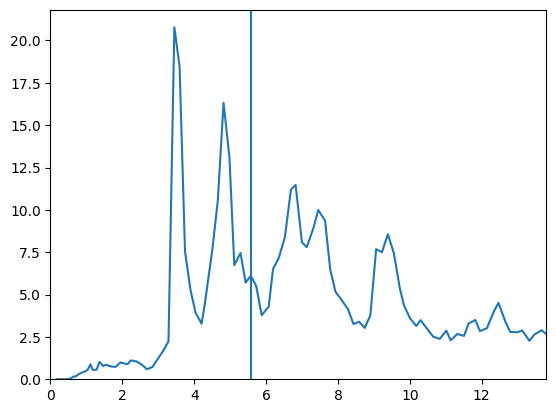

In [35]:
plt.plot(treeMPB['Time'], treeMPB['SubhaloSFRinRad'])
plt.axvline(meta['time'][48])
plt.ylim(0, None)
plt.xlim(0, get_time(1))

(0.0, 13.80271998548524)

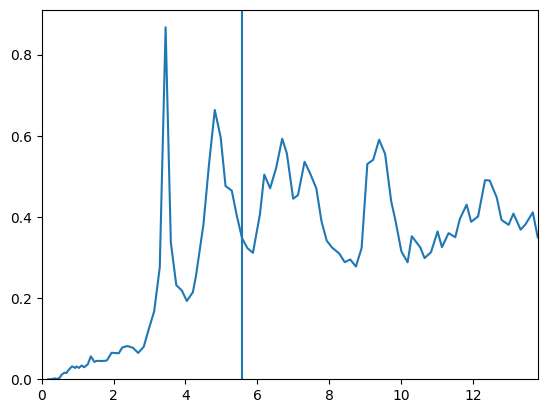

In [37]:
plt.plot(treeMPB['Time'], treeMPB['SubhaloMassInRadType'][:,0])
plt.axvline(meta['time'][48])
plt.ylim(0, None)
plt.xlim(0, get_time(1))

(0.0, 13.80271998548524)

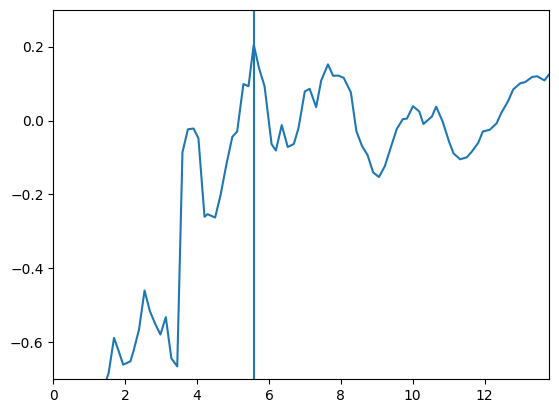

In [45]:
logFeH = np.log10(treeMPB['SubhaloGasMetalFractionsSfrWeighted'][:,8]/GFM_SOLAR_ABUNDANCE_IRON)
plt.plot(treeMPB['Time'], logFeH)
plt.axvline(meta['time'][48])
plt.ylim(-0.7, 0.3)
plt.xlim(0, get_time(1))

In [33]:
list(treeMPB.keys())

['count',
 'DescendantID',
 'FirstProgenitorID',
 'FirstSubhaloInFOFGroupID',
 'GroupBHMass',
 'GroupBHMdot',
 'GroupCM',
 'GroupFirstSub',
 'GroupGasMetalFractions',
 'GroupGasMetallicity',
 'GroupLen',
 'GroupLenType',
 'GroupMass',
 'GroupMassType',
 'GroupNsubs',
 'GroupPos',
 'GroupSFR',
 'GroupStarMetalFractions',
 'GroupStarMetallicity',
 'GroupVel',
 'GroupWindMass',
 'Group_M_Crit200',
 'Group_M_Crit500',
 'Group_M_Mean200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_Crit500',
 'Group_R_Mean200',
 'Group_R_TopHat200',
 'LastProgenitorID',
 'MainLeafProgenitorID',
 'Mass',
 'MassHistory',
 'NextProgenitorID',
 'NextSubhaloInFOFGroupID',
 'NumParticles',
 'RootDescendantID',
 'SnapNum',
 'SubfindID',
 'SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloCM',
 'SubhaloGasMetalFractions',
 'SubhaloGasMetalFractionsHalfRad',
 'SubhaloGasMetalFractionsMaxRad',
 'SubhaloGasMetalFractionsSfr',
 'SubhaloGasMetalFractionsSfrWeighted',
 'SubhaloGasMetallicity',
 'SubhaloGasMetallicityHal